In [2]:
from math import isnan, log, ceil
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.fftpack import rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn import svm, metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [3]:
def extract_meal_and_no_meal_instances(cgm_data_file, insulin_data_file):
    if ".xls" in cgm_data_file:
        cgm_df = pd.read_excel(cgm_data_file, parse_dates=[['Date', 'Time']])
    elif ".csv" in cgm_data_file:
        cgm_df = pd.read_csv(cgm_data_file, parse_dates=[
                             ['Date', 'Time']], low_memory=False)

    if ".xls" in insulin_data_file:
        insulin_df = pd.read_excel(
            insulin_data_file, parse_dates=[['Date', 'Time']])
    elif ".csv" in insulin_data_file:
        insulin_df = pd.read_csv(insulin_data_file, parse_dates=[
                                 ['Date', 'Time']], low_memory=False)

    # Filter only the needed fields to cp_df dataframe
    cp_df = cgm_df[['Date_Time', 'Sensor Glucose (mg/dL)']]
    cp_df = cp_df.set_index(['Date_Time'])
    cp_df.sort_index(inplace=True)

    # Filter only the needed fields to cp_ins_df dataframe
    cp_ins_df = insulin_df[['Date_Time', 'BWZ Carb Input (grams)']]

    # extract rows with Carb/meal intake values > 0
    meal_intake_rows = cp_ins_df.loc[cp_ins_df['BWZ Carb Input (grams)'] > 0, [
        'Date_Time', 'BWZ Carb Input (grams)']]
    meal_intake_rows.sort_values(['Date_Time'], inplace=True)
    meal_intake_rows.reset_index(inplace=True)
    meal_intake_rows.drop('index', inplace=True, axis=1)
    # 'BWZ Carb Input (grams)'
    valid_meal_data_times = meal_intake_rows

    rows_to_drop = []
    last_date = valid_meal_data_times['Date_Time'][0]-timedelta(hours=10)

    for ind, row in valid_meal_data_times.iterrows():
        if row['Date_Time'] < (last_date+timedelta(hours=4)):
            rows_to_drop.append(ind-1)
        last_date = row['Date_Time']

    valid_meal_data_times.drop(rows_to_drop, inplace=True)
    valid_meal_data_times.reset_index(inplace=True)

    # Extract Meal and No_meal window data
    meal_data = pd.DataFrame()
    no_meal_data = pd.DataFrame()

    for ind, row in valid_meal_data_times.iterrows():
        # meal_time window data
        m_data = cp_df[row['Date_Time'] -
                       timedelta(minutes=30):row['Date_Time']+timedelta(hours=2)]
        # no_meal_time window data
        n_m_data = cp_df[row['Date_Time'] +
                         timedelta(hours=2):row['Date_Time']+timedelta(hours=4)]

        # m_data = pd.concat([m_data, row['BWZ Carb Input (grams)']], axis=1)

        m_data.reset_index(inplace=True)
        n_m_data.reset_index(inplace=True)

        # Avoid meal and no_meal data instances with less than 30 and 24 observations respectively on a particular time window
        # Avoid instances with more than 5 NaN values
        if (len(m_data) >= 30) and (m_data['Sensor Glucose (mg/dL)'][:30].isna().sum() <= 5):
        # if (len(m_data) >= 30):
            m_data = m_data['Sensor Glucose (mg/dL)'][:30]
            m_data.at[30] = row['BWZ Carb Input (grams)']
            # m_data.set_value(30, row['BWZ Carb Input (grams)'])
            meal_data = pd.concat(
                [meal_data, m_data], ignore_index=True, axis=1)
            # print(row['BWZ Carb Input (grams)'])
            # print(m_data)

        if (len(n_m_data) >= 24) and (n_m_data['Sensor Glucose (mg/dL)'][:24].isna().sum() <= 5):
        # if (len(n_m_data) >= 24):
            no_meal_data = pd.concat(
                [no_meal_data, n_m_data['Sensor Glucose (mg/dL)'][:24]], ignore_index=True, axis=1)

    meal_data = meal_data.transpose()
    no_meal_data = no_meal_data.transpose()

    return [meal_data, no_meal_data]

In [4]:
def calcSlope(series):
    res = np.polyfit(range(len(series)), series, 1)
    return res[0]
    
def extract_features(data_matrix, features, is_meal=True):

    if is_meal:
        cols = features+["carbs"]
    else:
        cols = features
    feature_matrix = pd.DataFrame(columns=cols)
    slope_sampling_size = 2
    num_of_zcs = 3
    num_of_fds = 3

    app_ci = True
    app_dist = True

    for ind, data in data_matrix.iterrows():

        # print(data)
        # print(ind)

        carb_val = None
        if is_meal:
            carb_val = data.iloc[30]
            data.drop(30, inplace=True)
        # Max-Min Distance Feature
        f1_diff = data.max() - data.min()
        if isnan(f1_diff):
            continue


        # Slope feature
        slope_res = data.rolling(slope_sampling_size).apply(calcSlope, raw=False)
        slope_res = slope_res.fillna(0)

        f5_maxSlope = max(slope_res)

        zero_crossings = np.where(np.diff(np.sign(slope_res)))[
            0]   # Zero crossing indexes of slope
        zero_crossings = np.hstack(
            [zero_crossings, np.array(len(slope_res)-1)])
        zero_cross_dist_df = pd.DataFrame(columns=['cross_index', 'distance'])
        zc_idx = 0
        for idx, slope_idx in enumerate(zero_crossings):
            if (idx < 2) or (idx == (len(zero_crossings)-1)):
                pass
            else:
                # Calculate the dist between Max and Min slopes on either sides of a zero crossing
                # Max and Min sides depends on the sign of slope at zero crossing (if '-', the curve is increasing (Max->right, Min->left) and vice versa)
                if slope_res[slope_idx] < 0:
                    dist = max(slope_res[slope_idx:zero_crossings[idx+1]+1]) - \
                        min(slope_res[zero_crossings[idx-1]:slope_idx+1])
                else:
                    dist = max(slope_res[zero_crossings[idx-1]:slope_idx+1]) - \
                        min(slope_res[slope_idx:zero_crossings[idx+1]+1])
                zero_cross_dist_df.loc[zc_idx] = [slope_idx, dist]
                zc_idx += 1

        zero_cross_dist_df.sort_values(
            ['distance'], inplace=True, ascending=False)
        zero_cross_dist_df.reset_index(inplace=True)

        f2_slope_zero_cross_ordered_dist = []
        len_zero_cross_dist_df = len(zero_cross_dist_df)

        if len_zero_cross_dist_df < 3:
            # # Skip data that has less than three slope zero crossings
            continue

        for i in range(num_of_zcs):
            if (app_dist):
                f2_slope_zero_cross_ordered_dist.append(
                    zero_cross_dist_df.loc[i, ['distance']].values[0])
            if (app_ci):
                f2_slope_zero_cross_ordered_dist.append(
                    zero_cross_dist_df.loc[i, ['cross_index']].values[0])

        # Max-Min Value Index range/distance Feature
        f3_slot_diff = abs(data.idxmax() - data.idxmin())
        if isnan(f3_slot_diff):
            continue

        f6_max_meal_time = (data.idxmax() * 5)  # time to reach max glucose in minutes
        # print(f6_max_meal_time)

        # Frequency Domain Feature
        # Normalize data
        norm_data = data - data.mean()

        yf = rfft(norm_data.values)
        xf = rfftfreq(len(norm_data))
        yf = np.abs(yf)

        # Extract peaks
        peak_idxs, _ = find_peaks(yf)
        peaks = yf[peak_idxs]
        peaks.sort()
        peaks = peaks[::-1]
        f4_freq_domain = list(peaks[:num_of_fds])
        if len(f4_freq_domain) < num_of_fds:
            # # Skip data that has less than 3 frequency peaks after FFT
            continue
        if is_meal:
            # print(feature_matrix.columns)
            # print(f5_maxSlope, f6_max_meal_time)
            # print([f1_diff] + f2_slope_zero_cross_ordered_dist + \
            #     [f3_slot_diff] + f4_freq_domain + [f5_maxSlope, f6_max_meal_time, carb_val])
            feature_matrix.loc[ind] = [f1_diff] + f2_slope_zero_cross_ordered_dist + \
                [f3_slot_diff] + f4_freq_domain + [f5_maxSlope, f6_max_meal_time, carb_val]
        else:
            feature_matrix.loc[ind] = [f1_diff] + f2_slope_zero_cross_ordered_dist + \
                [f3_slot_diff] + f4_freq_domain + [f5_maxSlope, f6_max_meal_time]

    return feature_matrix

In [5]:
def split_data_label_sets(data_matrix_1, features, target):

    x_train = np.array(data_matrix_1.loc[:, features])
    # train_data_2 = data_matrix_2.loc[:, features].to_numpy()

    y_train = np.array(data_matrix_1.loc[:, [target]])
    # train_label_2 = data_matrix_2.loc[:, [target]].to_numpy()

    # x_train = np.vstack([train_data_1, train_data_2])
    # y_train = np.vstack([train_label_1, train_label_2])

    return [x_train, y_train]


In [6]:
def calc_entropy(split_counts, n):
    res = 0
    for key in split_counts.keys():
        fraction = float(split_counts[key])/n
        res -= ((fraction)*(log(fraction, 2.0)))
    return res

def calc_entropy_from_matrix(matrix, total_value_count):
    weighted_entropy = []
    for cluster in matrix.keys():
        cluster_entropy = 0
        cluster_val_count = sum(matrix[cluster].values())
        for bin in matrix[cluster].keys():
            fraction = float(matrix[cluster][bin])/cluster_val_count
            cluster_entropy -= ((fraction)*(log(fraction, 2.0)))
        weighted_entropy.append((float(cluster_val_count)/total_value_count)*cluster_entropy)
    # print(weighted_entropy)
    return(sum(weighted_entropy))

def calc_purity_from_matrix(matrix, total_value_count):
    weighted_purity = []
    for cluster in matrix.keys():
        cluster_purity = 0.0
        cluster_val_count = sum(matrix[cluster].values())
        for bin in matrix[cluster].keys():
            cluster_purity = max(cluster_purity, float(matrix[cluster][bin])/cluster_val_count)
        weighted_purity.append((float(cluster_val_count)/total_value_count)*cluster_purity)
    # print(weighted_purity)
    return(sum(weighted_purity))

def calc_purity(split_counts, n):
    res = 0.0
    for key in split_counts.keys():
        res = max(res, float(split_counts[key])/n)
    return res

In [7]:
def build_matrix(predictions, carb_values):
    gt_pred_matrix = defaultdict(lambda: defaultdict(int))
    min_carb = min(carb_values)
    i = 0
    while i < len(predictions):
        gt_pred_matrix[predictions[i]][int((carb_values[i]-min_carb)/20)] += 1
        i+=1
    return gt_pred_matrix
    

# ENTRY POINT

In [8]:
# Entry Point

#FROMAT: [cgm_data, insulin_data]
# training_input_files = [["data/CGMData.csv", "data/InsulinData.csv"]]
                        # ["data/CGMData670GPatient3.csv", "data/InsulinAndMealIntake670GPatient3.csv"]]

# meal_train_data_matrix_1, no_meal_train_data_matrix_1 = extract_meal_and_no_meal_instances(
#     training_input_files[0][0], training_input_files[0][1])
# meal_train_data_matrix_2, no_meal_train_data_matrix_2 = extract_meal_and_no_meal_instances(
#     training_input_files[1][0], training_input_files[1][1])


training_input_files = [
    ["CGMData.csv", "InsulinData.csv"]]
training_input_files = [
    ["data/CGMData.csv", "data/InsulinData.csv"]]
    # ["data/CGMData670GPatient3.csv", "data/InsulinAndMealIntake670GPatient3.csv"]]

meal_train_data_matrix_1, no_meal_train_data_matrix_1 = extract_meal_and_no_meal_instances(
    training_input_files[0][0], training_input_files[0][1])


In [9]:
# meal_train_data_matrix_1.fillna(meal_train_data_matrix_1.mean(axis=1), axis=1)
# meal_train_data_matrix_1 = meal_train_data_matrix_1.T.fillna(meal_train_data_matrix_1.mean(axis=1)).T

In [36]:
meal_train_data_matrix_1[:1].values

array([[ 58.,  59.,  63.,  71.,  81., 102., 131., 140., 147., 153., 159.,
        163., 159., 153., 151., 155., 163., 164.,  nan, 166., 168., 164.,
        169., 178., 184., 190., 195., 198., 203., 196., 115.]])

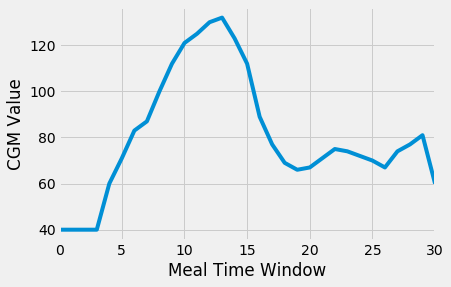

In [51]:
# plt.style.use("fivethirtyeight")
row = meal_train_data_matrix_1.iloc[2]
# row = no_meal_train_data_matrix_1.iloc[2]
row.plot(kind="line")
# plt.xticks(range(1, 30))
plt.xlabel("Meal Time Window")
plt.ylabel("CGM Value")
plt.show()

In [12]:
# print(meal_train_data_matrix_1.iloc[0:5, [x for x in range(30)]])
# print(meal_train_data_matrix_1.iloc[:, [30]])
max_carb = meal_train_data_matrix_1.iloc[:, [30]].max()
min_carb = meal_train_data_matrix_1.iloc[:, [30]].min()
# meal_train_data_matrix_1.drop(30, inplace=True, axis=1)
# print(meal_train_data_matrix_1.head(5))
# print(carbs)
# print(max_carb)
# print(min_carb)

In [13]:
features = ['f1_diff',
            'f2_slope_cross_dist_1',
            'f2_slope_cross_slot_1',
            'f2_slope_cross_dist_2',
            'f2_slope_cross_slot_2',
            'f2_slope_cross_dist_3',
            'f2_slope_cross_slot_3',
            'f3_slot_diff',
            'f4_dom_freq_1',
            'f4_dom_freq_2',
            'f4_dom_freq_3',
            'f5_max_slope',
            'f6_time_to_max_insulin']

meal_feature_1 = extract_features(meal_train_data_matrix_1, features, True)


In [14]:
features = ['f1_diff',
            'f2_slope_cross_dist_1',
            'f2_slope_cross_slot_1',
            'f2_slope_cross_dist_2',
            'f2_slope_cross_slot_2',
            'f2_slope_cross_dist_3',
            'f2_slope_cross_slot_3',
            'f3_slot_diff',
            'f4_dom_freq_1',
            'f4_dom_freq_2',
            'f4_dom_freq_3',
            'f5_max_slope',
            'f6_time_to_max_insulin']
            
target = 'carbs'
x_train_1, y_train_1 = split_data_label_sets(
    meal_feature_1, features, target)

In [15]:
# Ground truth based on carbs input:
meal_bin_label = []
n_bins = ceil((max_carb-min_carb)/20)
for carb in y_train_1:
    meal_bin_label.append(int((carb-min_carb)/20))
# for ind, carb in meal_train_data_matrix_1.iloc[:, [30]].iterrows():
#     meal_bin_label.append(int((carb[30]-min_carb)/20))
meal_bin_label = np.array(meal_bin_label)
# print(n_bins)
# print(meal_bin_label[:])
# print(meal_train_data_matrix_1.iloc[:, [30]])

In [16]:
pca_param_grid = {'whiten': [True, False],
                  'svd_solver': ['auto'],
                  'copy': [True],
                  'tol': [0.0, 0.1, 0.01, 0.001, 1.0, 0.0001],
                  'iterated_power': ['auto', 1, 10, 100, 1000],
                #   'n_components': [0.90, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]}
                  'n_components': [3, 4, 6, 7]}
                  # 'n_components': [4]}

pca = GridSearchCV(PCA(), pca_param_grid, refit=True, verbose=1)

In [17]:
# Standardization

# feature_mean_1 = x_train_1.mean(axis=0)
# feature_max_min_diff_1 = x_train_1.max(axis=0) - x_train_1.min(axis=0)

std_scalar = StandardScaler()
std_scalar.fit(x_train_1)


x_train_1 = std_scalar.transform(x_train_1)

# PCA

pca.fit(x_train_1)

# CLUSTER
# kmeans.fit(x_train_1)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    0.8s finished
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svd_solver': ['auto'], 'iterated_power': ['auto', 1, 10, 100, 1000], 'n_components': [3, 4, 6, 7], 'tol': [0.0, 0.1, 0.01, 0.001, 1.0, 0.0001], 'copy': [True], 'whiten': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [18]:
# x_train_1 = pca.transform(x_train_1)

In [19]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

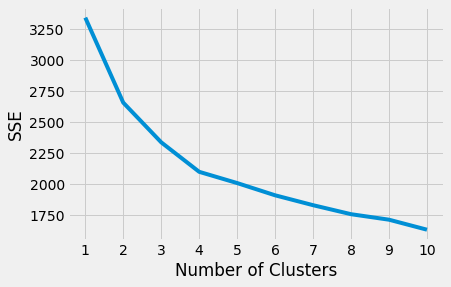

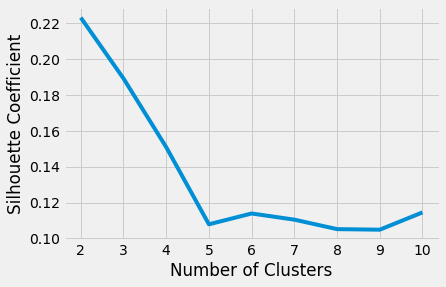

In [20]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_train_1)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
# # A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_train_1)
    score = silhouette_score(x_train_1, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [21]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(x_train_1)
distances, indices = nbrs.kneighbors(x_train_1)
# print(distances.mean(axis=0))
# for i in range(len(distances)):
#     print(indices[i][:], distances[i][1])

In [22]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=6)
# With FillNA
# dbscan = DBSCAN(eps=1, min_samples=10) # Working with PCA
# dbscan = DBSCAN(eps=1.7, min_samples=4) # Working without PCA
# dbscan = DBSCAN(eps=1.5, min_samples=5)

# Without FillNa
dbscan = DBSCAN(eps=1.7, min_samples=4)

In [23]:
# Fit the algorithms to the features
# print(x_train_1)
kmeans.fit(x_train_1)
dbscan.fit(x_train_1)


DBSCAN(algorithm='auto', eps=1.7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=None, p=None)

In [24]:
dbscan.labels_

array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1,  0, -1,
       -1,  0, -1, -1,  2, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  2, -1,  3,  1, -1, -1, -1, -1, -1,  3, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
        3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  2, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [25]:
def getMaxsse(input_dict):
    maxi = [0, 0]
    for key in input_dict.keys():
        # print(input_dict)
        if input_dict[key] > maxi[1]:
            maxi = [key, input_dict[key]]
    return maxi[0]

def calculate_cluster_wise_sse(points, pred_cluster_labels, ground_truth_labels, get_max_sse_cluster=False):
    cluster_points = defaultdict(list)
    cluster_point_labels = defaultdict(list)
    i = 0
    for feat, pred_lab, gt_label in zip(points, pred_cluster_labels, ground_truth_labels):
    # for feat, pred_lab, carb in zip(x_train_1, kmeans.labels_, y_train_1):
        # print("\nIndex: {}\nFeatures: {}, \nBin: {}".format(ind, feat, pred_lab))
        cluster_points[pred_lab].append(feat)
        cluster_point_labels[pred_lab].append(gt_label)

    cluster_centroids = defaultdict(list)

    for cluster in cluster_points.keys():
        cluster_centroids[cluster] = np.mean(cluster_points[cluster], axis=0)

    # Calculate SSE
    cluster_sse = defaultdict(int)

    for cluster in cluster_points.keys():
        for point in cluster_points[cluster]:
            cluster_sse[cluster] += np.sum(np.square(point - cluster_centroids[cluster]))

    if get_max_sse_cluster:
        # print(cluster_sse)
        max_sse_cluster = getMaxsse(cluster_sse)
        return (cluster_points[max_sse_cluster], max_sse_cluster, cluster_point_labels[max_sse_cluster], cluster_sse)
    return cluster_sse
    


In [26]:
def dbscan_with_bisecting_kmeans(data_points, label_start):
    # print(data_points)
    bis_kmeans = KMeans(n_clusters=2)
    bis_kmeans.fit(data_points)
    return bis_kmeans.labels_ + label_start

In [27]:
# %%
# K-Means
kMeans_class_split = defaultdict(int)
dbscan_class_split = defaultdict(int)

for clas in kmeans.labels_:
    kMeans_class_split[clas+1] += 1

for clas in dbscan.labels_:
    dbscan_class_split[clas+1] += 1


#TODO: Compute Clusterwise SSE of DBSCAN and do bisecting K-Means

kMeans_cluster_sse = calculate_cluster_wise_sse(x_train_1, kmeans.labels_, y_train_1)

dbscan_labels = dbscan.labels_

dbscan_max_sse_cluster_points, dbscan_max_sse_cluster, dbscan_max_sse_cluster_gt_labels, dbscan_cluster_sse = calculate_cluster_wise_sse(x_train_1, dbscan_labels, y_train_1, True)
# print(dbscan_max_sse_cluster)
number_of_dbscan_clusters = len(dbscan_cluster_sse.values())

# DO Bisecting K-Means on highest SSE clusters until n_bins clusters are achieved
while number_of_dbscan_clusters < n_bins:
    dbscan_bis_labels = dbscan_with_bisecting_kmeans(dbscan_max_sse_cluster_points, max(dbscan_cluster_sse.keys())+1)
    j = 0
    for i in range(len(dbscan_labels)):
        if dbscan_labels[i] == dbscan_max_sse_cluster:
            dbscan_labels[i] = dbscan_bis_labels[j]
            j += 1
    dbscan_max_sse_cluster_points, dbscan_max_sse_cluster, dbscan_max_sse_cluster_gt_labels, dbscan_cluster_sse = calculate_cluster_wise_sse(x_train_1, dbscan_labels, y_train_1, True)
    number_of_dbscan_clusters = len(dbscan_cluster_sse.values())


kMeans_sse = sum(kMeans_cluster_sse.values())
dbscan_sse = sum(dbscan_cluster_sse.values())

kMeans_label_length = len(kmeans.labels_)
dbscan_label_length = len(dbscan_labels)

km_ground_truth_predict_matrix = build_matrix(kmeans.labels_, y_train_1)
dbs_ground_truth_predict_matrix = build_matrix(dbscan_labels, y_train_1)

kMeans_entropy = calc_entropy_from_matrix(km_ground_truth_predict_matrix, kMeans_label_length)

dbscan_entropy = calc_entropy_from_matrix(dbs_ground_truth_predict_matrix, dbscan_label_length)

kMeans_purity = calc_purity_from_matrix(km_ground_truth_predict_matrix, kMeans_label_length)

dbscan_purity = calc_purity_from_matrix(dbs_ground_truth_predict_matrix, dbscan_label_length)

# %% [markdown]
# # Export Result

# # %%
result = pd.DataFrame(columns=['SSE for KMeans', 'SSE for DBSCAN', 'Entropy for KMeans', 'Entropy for DBSCAN', 'Purity for KMeans', 'Purity for DBSCAN'])

result.loc[0] = [kMeans_sse, dbscan_sse, kMeans_entropy, dbscan_entropy, kMeans_purity, dbscan_purity]

result.to_csv('Result.csv', header=False, index=False)